In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# reflect the tables
Base=automap_base()
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)
inspector=inspect(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.

stations=engine.execute('SELECT * FROM Station')
print(stations.keys())

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The most recent date in the dataset is {most_recent_date}")

RMKeyView(['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])
The most recent date in the dataset is 2017-08-23


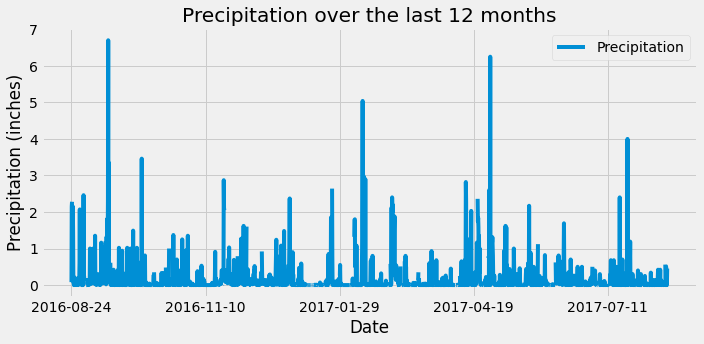

In [11]:
# calculate the date one year ago from the most recent date
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# perform a query to retrieve the last 12 months of precipitation data
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# sort the dataframe by date
df = df.sort_values('date')

# use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10,5))
df.plot(ax=ax, x_compat=True)

# set plot title and axis labels
plt.title("Precipitation over the last 12 months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

# set legend
plt.legend(["Precipitation"])

# show plot
plt.tight_layout()
plt.show()



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = df.describe()

print(summary_stats)

       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"There are a total of {total_stations} stations in the dataset.")

There are a total of 9 stations in the dataset.


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# Query to find the most active stations
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

most_active_station = most_active_stations[0][0]
print(f"The most active station is {most_active_station}.")

stations_by_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

print("Station Activity Summary:")
for station, count in stations_by_activity:
    print(f"Station {station} has {count} rows of data.")


The most active station is USC00519281.
Station Activity Summary:
Station USC00519281 has 2772 rows of data.
Station USC00519397 has 2724 rows of data.
Station USC00513117 has 2709 rows of data.
Station USC00519523 has 2669 rows of data.
Station USC00516128 has 2612 rows of data.
Station USC00514830 has 2202 rows of data.
Station USC00511918 has 1979 rows of data.
Station USC00517948 has 1372 rows of data.
Station USC00518838 has 511 rows of data.


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperatures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all()

min_temp, max_temp, avg_temp = temperatures[0]
print(f"For the most active station ({most_active_station}):")
print(f"  - Lowest temperature: {min_temp}")
print(f"  - Highest temperature: {max_temp}")
print(f"  - Average temperature: {avg_temp:.2f}")


For the most active station (USC00519281):
  - Lowest temperature: 54.0
  - Highest temperature: 85.0
  - Average temperature: 71.66


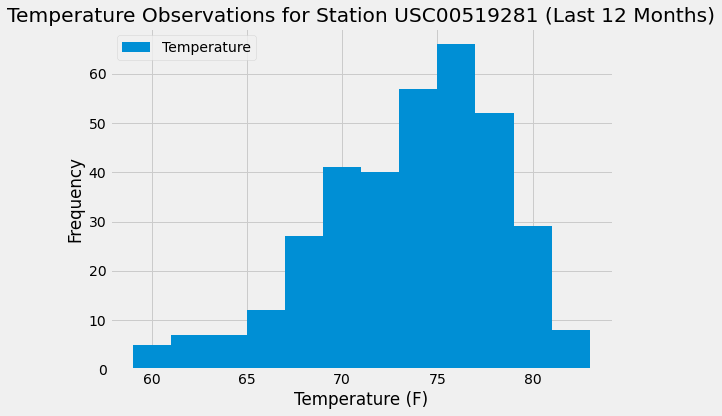

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temps = session.query(Measurement.tobs).\
                    filter(Measurement.station == most_active_station).\
                    filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a Pandas DataFrame
temps_df = pd.DataFrame(last_year_temps, columns=['Temperature'])

# Plot the results as a histogram
fig, ax = plt.subplots(figsize=(8,6))
temps_df.plot.hist(bins=12, ax=ax)

# Set plot title and axis labels
plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")

# Show plot
plt.tight_layout()
plt.show()



# Close session

In [20]:
# Close Session
session.close()